In [1]:
import pandas as pd
import os 
import glob
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fft import fft
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("done")


done


In [2]:
def create_windows(data, threshold):
    start_time = data['timestamp'].iloc[0]
    end_time = data['timestamp'].iloc[-1]
    
    intervals = pd.date_range(start=start_time, end=end_time, freq = '1s')
    
    windows = []
    labels = []
    
    for i in range(len(intervals) - 1):
        start = intervals[i]
        end = intervals[i+1]
        
        window_data = data[(data['timestamp'] >= start) & (data['timestamp'] < end)]
        
        if len(window_data) >= threshold:
            windows.append(window_data[['thigh_x', 'thigh_y', 'thigh_z']].values)
            
            labels.append(window_data['label'].mode()[0])
            
    return windows, labels
print("Done") 

Done


In [3]:
def extract_features(windows):
    features = []

    for i, window in enumerate(windows):

        feature_dict = {}
        x, y, z = window[:, 0], window[:, 1], window[:, 2]

        # Basic Features
        feature_dict['X_mean'] = np.mean(x)
        feature_dict['Y_mean'] = np.mean(y)
        feature_dict['Z_mean'] = np.mean(z)

        feature_dict['X_stdev'] = np.std(x)
        feature_dict['Y_stdev'] = np.std(y)
        feature_dict['Z_stdev'] = np.std(z)

        feature_dict['X_range'] = np.max(x) - np.min(x)
        feature_dict['Y_range'] = np.max(y) - np.min(y)
        feature_dict['Z_range'] = np.max(z) - np.min(z)

        # Correlation Features (with safety checks)
        feature_dict['Corr_xy'] = safe_corrcoef(x, y)
        feature_dict['Corr_yz'] = safe_corrcoef(y, z)
        feature_dict['Corr_xz'] = safe_corrcoef(x, z)

        # Vector Magnitude
        vector_magnitude = np.sqrt(x**2 + y**2 + z**2)
        feature_dict['||e||2_mean'] = np.mean(vector_magnitude)
        feature_dict['||e||2_range'] = np.max(vector_magnitude) - np.min(vector_magnitude)
        feature_dict['||e||2_median'] = np.median(vector_magnitude)
        feature_dict['||e||2_skew'] = skew(vector_magnitude)
        feature_dict['||e||2_stdev'] = np.std(vector_magnitude)
        feature_dict['||e||2_absdev'] = np.mean(np.abs(vector_magnitude - np.mean(vector_magnitude)))

        # Kurtosis
        feature_dict['kurtosis'] = kurtosis(vector_magnitude)

        # Power Spectral Features
        fft_vals = np.abs(fft(vector_magnitude))
        feature_dict['Pow1'] = np.sum(fft_vals[:len(fft_vals)//4])
        feature_dict['Pow2'] = np.sum(fft_vals[len(fft_vals)//4:len(fft_vals)//2])

        features.append(feature_dict)

    features_df = pd.DataFrame(features)

    features_df.fillna(0, inplace=True)
    features_df.replace([np.inf, -np.inf], 0, inplace=True)

    return features_df


# Safe correlation calculation
def safe_corrcoef(a, b):
    if len(a) < 2 or np.std(a) == 0 or np.std(b) == 0:
        return np.nan  # or 0
    return np.corrcoef(a, b)[0, 1]
print("Complete")

Complete


In [4]:
threshold = 10

In [5]:
folder_path = 'thigh_dataset/harth/training_data'

csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

threshold = 10
all_features = []
all_labels = []

for file in csv_files:
    df = pd.read_csv(file)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    data = df.sort_values(by='timestamp')

    thigh_data = data[['timestamp', 'thigh_x', 'thigh_y', 'thigh_z', 'label']]
    windows, labels = create_windows(thigh_data, threshold)

    print(f"No. of 1-s windows created: {len(windows)}")
    if len(windows) > 0:
        features_df = extract_features(windows)
        all_features.append(features_df)
        all_labels.extend(labels)

print("Feature extraction complete.")


No. of 1-s windows created: 7451
No. of 1-s windows created: 6790
No. of 1-s windows created: 5974
No. of 1-s windows created: 7420
No. of 1-s windows created: 3579
No. of 1-s windows created: 6069
No. of 1-s windows created: 2755
No. of 1-s windows created: 7376
No. of 1-s windows created: 8389
No. of 1-s windows created: 4117
No. of 1-s windows created: 7130
No. of 1-s windows created: 8403
No. of 1-s windows created: 3418
No. of 1-s windows created: 7669
No. of 1-s windows created: 3180
No. of 1-s windows created: 6475
No. of 1-s windows created: 7039
Feature extraction complete.


In [10]:

X = pd.concat(all_features, ignore_index=True)
y = all_labels


model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X, y)

print("Training Complete")

Training Complete


In [7]:
# Save the trained model
joblib.dump(model, 'activity_model.pkl')
print("Modle saving complete")

Modle saving complete


In [8]:
#Prediction

activity_mapping = {
    1: "Walking",
    2: "Running",
    3: "Shuffling",
    4: "Stairs (Ascending)",
    5: "Stairs (Descending)",
    6: "Standing",
    7: "Sitting",
    8: "Lying",
    13: "Cycling (Sit)",
    14: "Cycling (Stand)",
    130: "Cycling (Sit, Inactive)",
    140: "Cycling (Stand, Inactive)"
}

loaded_model = joblib.load('activity_model.pkl')

test_data_folder = 'thigh_dataset/harth/test_data'

all_true_labels = []
all_predicted_labels = []

for file_name in os.listdir(test_data_folder):
    if file_name.endswith('.csv'):
        file_path = os.path.join(test_data_folder, file_name)
        print(f"Processing file: {file_name}")
        
        new_data = pd.read_csv(file_path)
        
        new_data['timestamp'] = pd.to_datetime(new_data['timestamp'])
        
        new_data = new_data.sort_values(by='timestamp')
        
        new_windows, new_labels = create_windows(new_data, threshold)
        if len(new_windows) == 0:
            print(f"No valid windows found in {file_name}. Skipping...")
            continue
        
        new_features = extract_features(new_windows)
        new_features.fillna(0, inplace=True)  
        
        predictions = loaded_model.predict(new_features)
        
        predicted_activities = [activity_mapping.get(pred, "Unknown") for pred in predictions]
        
        all_true_labels.extend(new_labels)  
        all_predicted_labels.extend(predictions)  
        
        print(f"Predicted Activities for {file_name}:")
        for activity in predicted_activities:
            print(activity)
        print("\n" + "-" * 50 + "\n")

print("Complete")

Processing file: S025.csv
Predicted Activities for S025.csv:
Walking
Walking
Walking
Standing
Walking
Standing
Walking
Standing
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Shuffling
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sittin

Predicted Activities for S026.csv:
Walking
Shuffling
Walking
Shuffling
Standing
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Stairs (Descending)
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Stairs (Descending)
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Shuffling
Walking
Standing
Standing
Walking
Walking
Walking
Walking
Walking
Walk

Predicted Activities for S028.csv:
Standing
Standing
Standing
Standing
Standing
Shuffling
Walking
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Standing
Walking
Walking
Walking
Walking
Walking
Shuffling
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Shuffling
Standing
Shuffling
Walking
Shuffling
Walk

Predicted Activities for S009.csv:
Standing
Standing
Standing
Walking
Walking
Walking
Stairs (Ascending)
Walking
Walking
Stairs (Ascending)
Stairs (Ascending)
Stairs (Ascending)
Walking
Walking
Walking
Walking
Walking
Shuffling
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Walking
Standing
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Standing
Standing
Shuffling
Walking
Cycling (Sit)
Cycling (Sit)
Cycling (Sit)
Cycling (Sit)
Standing
Standing
Cycling (Sit)
Cycling (Sit)
Walking
Standing
Standing
Walking
Walking
Standing
Standing
Stairs (Ascending)
Standing
Standing
Standing
Cycling (Sit)
Cycling (Sit)
Cycling (Sit)
Cycling (Sit)
Cycling (Sit)
Stairs (Ascending)
Walking
Standing
Stairs (Ascending)
Standing
Standing
Walking
Walking
Cyc

Predicted Activities for S017.csv:
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Shuffling
Standing
Shuffling
Shuffling
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Shuffling
Shuffling
Walking
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Standing
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Shuffling
Standing
Sitting
Sitting
Standing
Shuffling
Walking
Shuffling
Standing
Shuffling
Sitting
Shuffling
Shuffling
Shuff

In [9]:
# Evaluate the model
print("Model Evaluation:")
print("Accuracy:", accuracy_score(all_true_labels, all_predicted_labels))
print("Classification Report:\n", classification_report(all_true_labels, all_predicted_labels, zero_division = 0, target_names=list(activity_mapping.values())))


Model Evaluation:
Accuracy: 0.7791474292886279
Classification Report:
                            precision    recall  f1-score   support

                  Walking       0.67      0.96      0.79      5641
                  Running       0.95      0.85      0.90      1016
                Shuffling       0.27      0.16      0.20       445
       Stairs (Ascending)       0.36      0.16      0.22       412
      Stairs (Descending)       0.35      0.05      0.09       403
                 Standing       0.67      0.85      0.75      1291
                  Sitting       0.83      0.99      0.90      4685
                    Lying       0.96      0.43      0.59      1326
            Cycling (Sit)       0.93      0.84      0.88      5504
          Cycling (Stand)       0.59      0.05      0.09       943
  Cycling (Sit, Inactive)       0.36      0.01      0.02       510
Cycling (Stand, Inactive)       0.00      0.00      0.00       133

                 accuracy                           0.78

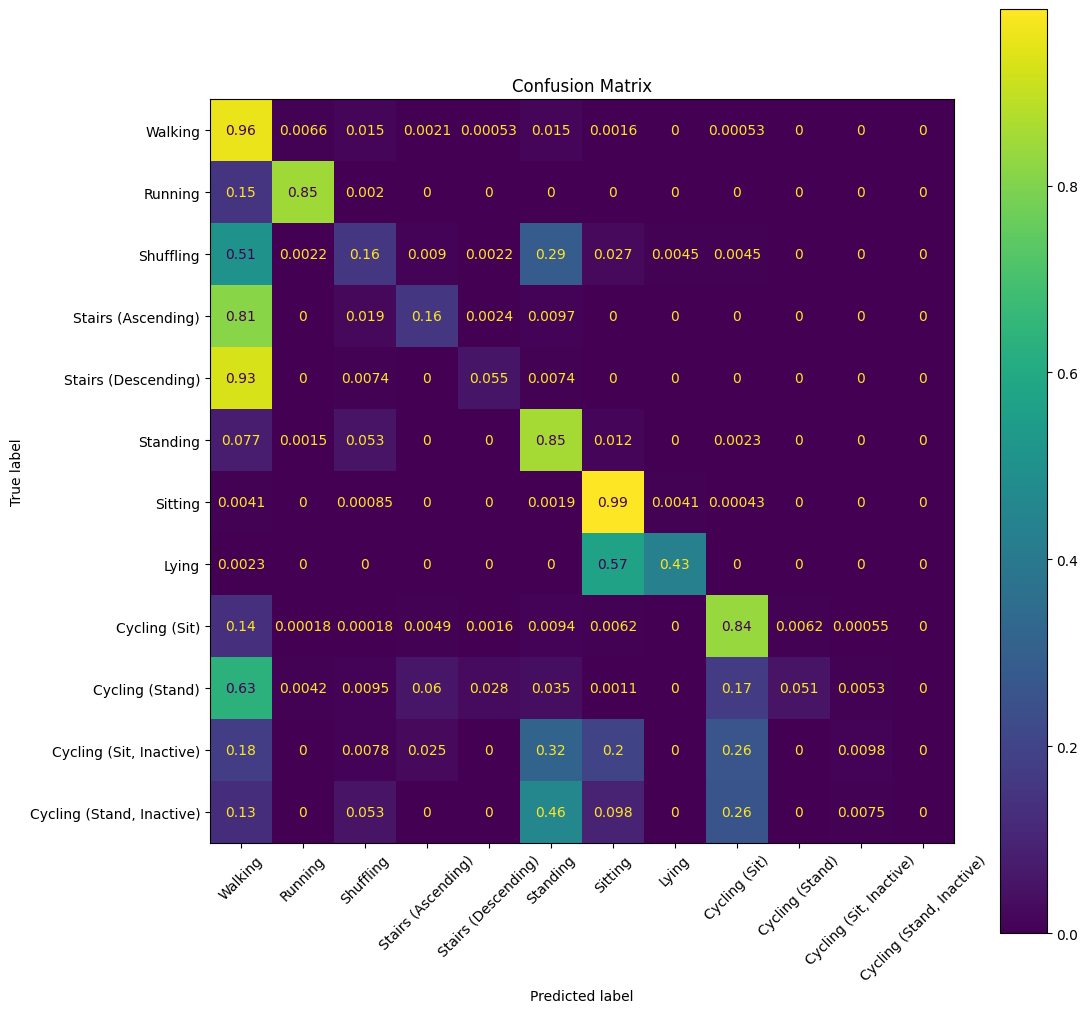

In [18]:
# Confusion matrix
cm = confusion_matrix(all_true_labels, all_predicted_labels, normalize='true')
classes = list(activity_mapping.values()) 

plt.figure(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.viridis, xticks_rotation=45, ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()